Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
from tqdm import tqdm
from queue import PriorityQueue

## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [4]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [6]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [7]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)

# Use a cache to improve computation time of this function
#analize_cache = dict()
def analize(raw: Nim) -> dict:
    # global analize_cache
    # cached_value = analize_cache.get(raw)
    # if cached_value is not None:
    #     key = list(analize_cache.keys())[list(analize_cache.values()).index(cached_value)]
    #     print(raw, key)
    #     return cached_value
    # else :
        cooked = dict()
        cooked["possible_moves"] = dict()
        for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
            tmp = deepcopy(raw)
            tmp.nimming(ply)
            cooked["possible_moves"][ply] = nim_sum(tmp)
        #analize_cache[raw] = cooked
        #print(raw, "added in cache -->", cooked)
        return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [8]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, optimal)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=3)
INFO:root:status: <1 3 5 4 9>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=7)
INFO:root:status: <1 3 5 4 2>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=4)
INFO:root:status: <1 3 5 0 2>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 0 2>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <0 3 2 0 2>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 3 2 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 2 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 0 2 0 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 1 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


## Automatic comparison of strategies

In [57]:
# Run 100 games with the given parameters and print number of victories for each player
def compare_strategies(plyr1_strat, plyr2_strat, nim_size) :
    strategy = (plyr1_strat, plyr2_strat)
    plyr1_victories = 0
    plyr2_victories = 0
    for _ in tqdm(range(100)) :
        nim = Nim(nim_size)
        player = 0
        while nim:
            ply = strategy[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 0 :
            plyr1_victories += 1
        else :
            plyr2_victories += 1
    
    results = (plyr1_victories, plyr2_victories)
    print("Victories -> Player 1 :", plyr1_victories, ", Player 2 :", plyr2_victories)
    return results

## First task : Improve rule-based agent

In [10]:
def optimal_rule_based1(state : Nim) -> Nimply :
    # We keep the basic idea : we first have to filter the good moves before selecting one
    analysis = analize(state)
    good_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
   
    # If there is no good move, we can only select one random bad move
    if not good_moves:
        good_moves = list(analysis["possible_moves"].keys())
        ply = random.choice(good_moves)
        return ply
    
    # The best move one can make is the one that lets no good move to their opponent
    best_moves = list()
    for ply in good_moves :
        tmp_nim = deepcopy(state)
        tmp_nim.nimming(ply)
        opponent_moves = analize(tmp_nim)["possible_moves"]
        good_opponent_moves = [ply for ply,ns in opponent_moves.items() if ns != 0]
        if not good_opponent_moves :
            best_moves.append(ply)
    
    # If there are best moves, the agent can randomly choose one of them
    if len(best_moves) > 0 :
        ply = random.choice(best_moves)
        return ply
    
    # If there are no best moves, agent can only choose a good move
    ply = random.choice(good_moves)
    return ply

In [11]:
def optimal_rule_based2(state : Nim) -> Nimply :
    # We keep the basic idea : we first have to filter the good moves before selecting one
    analysis = analize(state)
    good_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
   
    # If there is no good move, we can only select one random bad move
    if not good_moves:
        good_moves = list(analysis["possible_moves"].keys())
        ply = random.choice(good_moves)
        return ply
    
    # The possible moves are sorted regarding the number of good moves they let to the opponent
    sorted_good_moves = PriorityQueue()
    for ply in good_moves :
        tmp_nim = deepcopy(state)
        tmp_nim.nimming(ply)
        opponent_moves = analize(tmp_nim)["possible_moves"]
        good_opponent_moves = [ply for ply,ns in opponent_moves.items() if ns != 0]
        sorted_good_moves.put((len(good_opponent_moves), ply))
    
    # We always choose the move that lets the lesser good moves to the opponent
    _, ply = sorted_good_moves.get()
    return ply

In [12]:
def optimal_rule_based3(state : Nim) -> Nimply :
    # We keep the basic idea : we first have to filter the good moves before selecting one
    analysis = analize(state)
    good_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
   
    # If there is no good move, we can still apply the strategy of taking the move that lets the less godd moves to the opponent
    if not good_moves:
        good_moves = list(analysis["possible_moves"].keys())
    
    # The possible moves are sorted regarding the number of good moves they let to the opponent
    sorted_good_moves = PriorityQueue()
    for ply in good_moves :
        tmp_nim = deepcopy(state)
        tmp_nim.nimming(ply)
        opponent_moves = analize(tmp_nim)["possible_moves"]
        good_opponent_moves = [ply for ply,ns in opponent_moves.items() if ns != 0]
        sorted_good_moves.put((len(good_opponent_moves), ply))
    
    # We always choose the move that lets the lesser good moves to the opponent
    _, ply = sorted_good_moves.get()
    return ply

## Second task : create an evolutionary agent

In [26]:
class Evolutionary_Agent1 :
    def __init__(self, nim : Nim) -> None:
        self.limit = nim._k if nim._k is not None else np.max(nim.rows)
        self.rules = np.array([['np.sum(nim.rows) <=', random.randint(1,50), random.randint(1, len(nim.rows)) - 1, random.randint(1,self.limit)],
                      ['np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 1]) <=', random.randint(1,50), random.randint(1, len(nim.rows) - 1), random.randint(1,self.limit)],
                      ['np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 0]) <=', random.randint(1,50), random.randint(1, len(nim.rows) - 1), random.randint(1,self.limit)],
                      ], dtype=object)
    
    def default_move(self, nim : Nim) : 
        ply = Nimply(np.argmax(np.array(nim.rows) != 0), 1)
        return ply
    
    def strategy(self, nim : Nim) :
        for rule in self.rules :
            if eval(rule[0] + str(rule[1])) :
                ply = Nimply(rule[2], rule[3])
                # If the move is valid, make it
                if nim.rows[ply.row] >= ply.num_objects :
                    return ply
        # If no valid move was found, make the default move
        return self.default_move(nim)


In [75]:
# First real attempt to get results : the agent has a set of 100 evolving rules, 
# whose expression is randomly picked in a predetermined set
class Evolutionary_Agent2(Evolutionary_Agent1) :
    def __init__(self, nim: Nim) -> None:
        super().__init__(nim)
        possible_rules = ["np.sum(nim.rows) <=",
                          "np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 1]) <=",
                          "np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 0]) <=",
                          "np.sum(nim.rows) >",
                          "np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 1]) >",
                          "np.sum([row for i,row in enumerate(nim.rows) if i % 2 == 0]) >",
                          "np.count_nonzero(np.array(nim.rows) > 0) ==",
                          "np.count_nonzero(np.array(nim.rows) > 0) <=",
                          "np.count_nonzero(np.array(nim.rows) > 0) >="]
        self.rules = np.array([[random.choice(possible_rules), random.randint(1,50), random.randint(1, len(nim.rows)) - 1, random.randint(1,self.limit)] for _ in range(100)], dtype = object)
    
    # To prevent always the same rules from being applied, the strategy is to randomly choose
    # one move among the valid rules
    def strategy(self, nim : Nim) :
        valid_plys = []
        for rule in self.rules :
            if eval(rule[0] + str(rule[1])) :
                ply = Nimply(rule[2], rule[3])
                # If the move is valid, save it
                #print(ply.row)
                if nim.rows[ply.row] >= ply.num_objects :
                    valid_plys.append(ply)
        if len(valid_plys) > 0 :
            return random.choice(valid_plys)
        else :
            # If no valid move was found, make the default move
            return self.default_move(nim)
        

In [73]:
def evaluate_agent_fitness(agent : Evolutionary_Agent1, nim : Nim) :
    results = compare_strategies(agent.strategy, optimal_rule_based3, len(nim.rows))
    return results[0]

# Create lambda new agents using Gaussian mutations, then pick the best (original agent inluded)
def one_plus_lambda_evolve(agent : Evolutionary_Agent1, lamb : int, nim : Nim) :
    num_rows = len(agent.rules)
    # TODO : Self-adaptive sigmas
    sigmas = np.ones((num_rows, 3))    
    agents = [agent]
    for _ in range(lamb) :
        new_agent = deepcopy(agent)
        mutations = np.random.normal(np.zeros((num_rows,3)),np.ones((num_rows,3))).astype(int)
        new_agent.rules[:,1:] += mutations
        # Prevent invalid mutations from happening (negative thresholds or none object taken)
        new_agent.rules[:,1:] = np.maximum([[0,0,1] for _ in range(num_rows)], new_agent.rules[:,1:])
        new_agent.rules[:,1:] = np.minimum([[np.sum(nim.rows), len(nim.rows) - 1, np.argmax(nim.rows)] for _ in range(num_rows)], new_agent.rules[:,1:])
        agents.append(new_agent)
    
    fitness = []
    for a in agents :
        fitness.append(evaluate_agent_fitness(a, nim))
    
    return agents[np.argmax(fitness)]

# Create lambda new agents using Gaussian mutations, then pick the best (original agent excluded)
def one_comma_lambda_evolve(agent : Evolutionary_Agent1, lamb : int, nim : Nim) :
    num_rows = len(agent.rules)
    # TODO : Self-adaptive sigmas
    sigmas = np.ones((num_rows, 3))    
    agents = []
    for _ in range(lamb) :
        new_agent = deepcopy(agent)
        mutations = np.random.normal(np.zeros((num_rows,3)),np.ones((num_rows,3))).astype(int)
        new_agent.rules[:,1:] += mutations
        # Prevent invalid mutations from happening (negative thresholds or none object taken)
        new_agent.rules[:,1:] = np.maximum([[0,0,1] for _ in range(num_rows)], new_agent.rules[:,1:])
        new_agent.rules[:,1:] = np.minimum([[np.sum(nim.rows), len(nim.rows) - 1, np.argmax(nim.rows)] for _ in range(num_rows)], new_agent.rules[:,1:])
        agents.append(new_agent)
    
    fitness = []
    for a in agents :
        fitness.append(evaluate_agent_fitness(a, nim))
    
    return agents[np.argmax(fitness)]

In [78]:
nim = Nim(3)
test = Evolutionary_Agent2(nim)
#evaluate_agent_fitness(test, nim)
for _ in range(10) :
    test = one_plus_lambda_evolve(test, 10, nim)
print(evaluate_agent_fitness(test,nim))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 74.31it/s]


Victories -> Player 1 : 24 , Player 2 : 76


100%|██████████| 100/100 [00:01<00:00, 70.46it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 77.99it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 78.63it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 78.87it/s]


Victories -> Player 1 : 15 , Player 2 : 85


100%|██████████| 100/100 [00:01<00:00, 77.62it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 66.49it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 71.19it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 78.81it/s]


Victories -> Player 1 : 13 , Player 2 : 87


100%|██████████| 100/100 [00:01<00:00, 83.59it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 80.29it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 86.41it/s]


Victories -> Player 1 : 19 , Player 2 : 81


100%|██████████| 100/100 [00:01<00:00, 77.20it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 82.94it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 65.68it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 85.74it/s]


Victories -> Player 1 : 1 , Player 2 : 99


100%|██████████| 100/100 [00:01<00:00, 82.97it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 83.49it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 79.50it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 67.94it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 57.82it/s]


Victories -> Player 1 : 2 , Player 2 : 98


100%|██████████| 100/100 [00:01<00:00, 74.30it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 77.81it/s]


Victories -> Player 1 : 20 , Player 2 : 80


100%|██████████| 100/100 [00:01<00:00, 80.73it/s]


Victories -> Player 1 : 16 , Player 2 : 84


100%|██████████| 100/100 [00:01<00:00, 87.99it/s]


Victories -> Player 1 : 16 , Player 2 : 84


100%|██████████| 100/100 [00:01<00:00, 87.57it/s]


Victories -> Player 1 : 13 , Player 2 : 87


100%|██████████| 100/100 [00:01<00:00, 81.84it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 73.36it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 70.26it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 75.15it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 82.96it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 84.41it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 77.98it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 92.78it/s]


Victories -> Player 1 : 27 , Player 2 : 73


100%|██████████| 100/100 [00:01<00:00, 82.06it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 79.38it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 78.41it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 78.67it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


Victories -> Player 1 : 15 , Player 2 : 85


100%|██████████| 100/100 [00:01<00:00, 74.62it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 75.97it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 77.88it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 74.65it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 78.26it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 88.28it/s]


Victories -> Player 1 : 31 , Player 2 : 69


100%|██████████| 100/100 [00:01<00:00, 80.24it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 77.38it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 78.31it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 77.66it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 79.06it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 77.07it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 77.69it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 78.40it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 78.28it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 77.74it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 88.84it/s]


Victories -> Player 1 : 20 , Player 2 : 80


100%|██████████| 100/100 [00:01<00:00, 70.50it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 79.00it/s]


Victories -> Player 1 : 16 , Player 2 : 84


100%|██████████| 100/100 [00:01<00:00, 74.10it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 77.25it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 80.20it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 80.12it/s]


Victories -> Player 1 : 17 , Player 2 : 83


100%|██████████| 100/100 [00:01<00:00, 75.72it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 78.17it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 80.77it/s]


Victories -> Player 1 : 17 , Player 2 : 83


100%|██████████| 100/100 [00:01<00:00, 78.37it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 87.29it/s]


Victories -> Player 1 : 24 , Player 2 : 76


100%|██████████| 100/100 [00:01<00:00, 75.91it/s]


Victories -> Player 1 : 5 , Player 2 : 95


100%|██████████| 100/100 [00:01<00:00, 76.84it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 80.06it/s]


Victories -> Player 1 : 16 , Player 2 : 84


100%|██████████| 100/100 [00:01<00:00, 78.25it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 75.44it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 77.51it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 79.23it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 76.48it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 80.19it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 82.37it/s]


Victories -> Player 1 : 21 , Player 2 : 79


100%|██████████| 100/100 [00:01<00:00, 90.77it/s]


Victories -> Player 1 : 24 , Player 2 : 76


100%|██████████| 100/100 [00:01<00:00, 76.19it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 79.04it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 80.99it/s]


Victories -> Player 1 : 17 , Player 2 : 83


100%|██████████| 100/100 [00:01<00:00, 76.71it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 77.12it/s]


Victories -> Player 1 : 4 , Player 2 : 96


100%|██████████| 100/100 [00:01<00:00, 79.24it/s]


Victories -> Player 1 : 6 , Player 2 : 94


100%|██████████| 100/100 [00:01<00:00, 76.29it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 76.81it/s]


Victories -> Player 1 : 15 , Player 2 : 85


100%|██████████| 100/100 [00:01<00:00, 76.58it/s]


Victories -> Player 1 : 18 , Player 2 : 82


100%|██████████| 100/100 [00:01<00:00, 78.00it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 89.49it/s]


Victories -> Player 1 : 32 , Player 2 : 68


100%|██████████| 100/100 [00:01<00:00, 79.61it/s]


Victories -> Player 1 : 19 , Player 2 : 81


100%|██████████| 100/100 [00:01<00:00, 78.09it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 77.87it/s]


Victories -> Player 1 : 3 , Player 2 : 97


100%|██████████| 100/100 [00:01<00:00, 77.08it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 77.85it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 78.31it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 75.95it/s]


Victories -> Player 1 : 8 , Player 2 : 92


100%|██████████| 100/100 [00:01<00:00, 79.32it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 77.42it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 76.88it/s]


Victories -> Player 1 : 12 , Player 2 : 88


100%|██████████| 100/100 [00:01<00:00, 88.30it/s]


Victories -> Player 1 : 27 , Player 2 : 73


100%|██████████| 100/100 [00:01<00:00, 77.22it/s]


Victories -> Player 1 : 9 , Player 2 : 91


100%|██████████| 100/100 [00:01<00:00, 76.93it/s]


Victories -> Player 1 : 11 , Player 2 : 89


100%|██████████| 100/100 [00:01<00:00, 77.32it/s]


Victories -> Player 1 : 7 , Player 2 : 93


100%|██████████| 100/100 [00:01<00:00, 78.07it/s]


Victories -> Player 1 : 10 , Player 2 : 90


100%|██████████| 100/100 [00:01<00:00, 76.86it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 75.51it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 78.50it/s]


Victories -> Player 1 : 13 , Player 2 : 87


100%|██████████| 100/100 [00:01<00:00, 78.82it/s]


Victories -> Player 1 : 15 , Player 2 : 85


100%|██████████| 100/100 [00:01<00:00, 82.32it/s]


Victories -> Player 1 : 17 , Player 2 : 83


100%|██████████| 100/100 [00:01<00:00, 75.78it/s]


Victories -> Player 1 : 14 , Player 2 : 86


100%|██████████| 100/100 [00:01<00:00, 84.01it/s]

Victories -> Player 1 : 23 , Player 2 : 77
23


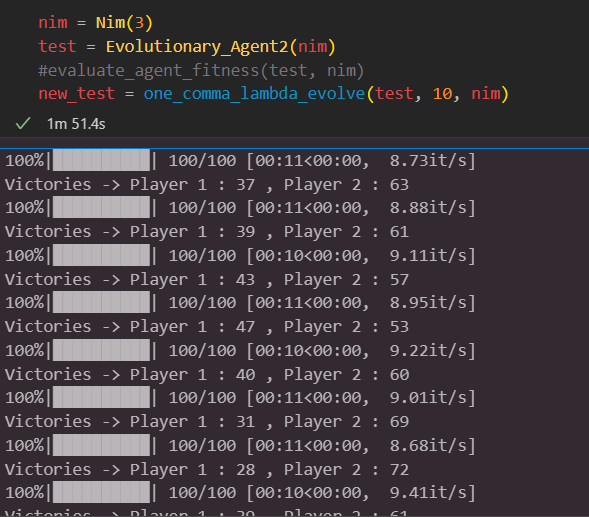

In [72]:
nim = Nim(3)
evaluate_agent_fitness(new_test, nim)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  9.01it/s]

Victories -> Player 1 : 27 , Player 2 : 73


27

In [33]:
tab = (0,3,0)
np.argmax(np.array(tab) != 0)

1